In [1]:
# Import Libraries and Data
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

!ls /kaggle/input/histopathologic-cancer-detection

sample_submission.csv  test  train  train_labels.csv


In [2]:
labels_path = "/kaggle/input/histopathologic-cancer-detection/train_labels.csv"
train_labels = pd.read_csv(labels_path)
train_labels.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


The id column: each row corresponds to an image file
The label column: 1 indicates tumor tissue present, 0 indicates no tumor.

# Basic Exploration of the Labels

Number of training samples: 220025
Missing values per column:
 id       0
label    0
dtype: int64


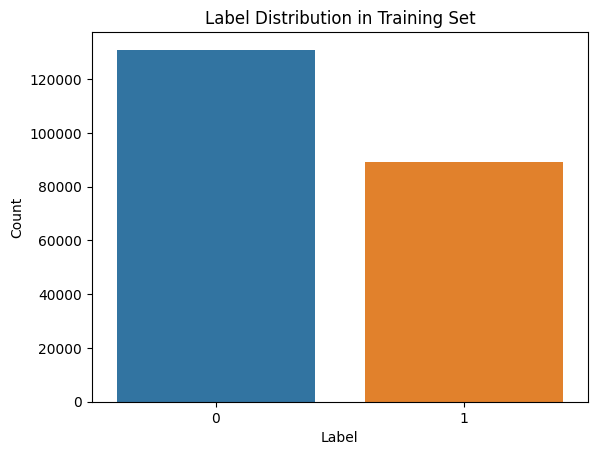

Number of negative (0) samples: 130908
Number of positive (1) samples: 89117


In [3]:
print("Number of training samples:", len(train_labels))
print("Missing values per column:\n", train_labels.isnull().sum())
label_counts = train_labels['label'].value_counts()
sns.barplot(x=label_counts.index, y=label_counts.values)
plt.title('Label Distribution in Training Set')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

# Print exact counts
print("Number of negative (0) samples:", label_counts[0])
print("Number of positive (1) samples:", label_counts[1])

**Visualize Some Sample Images**

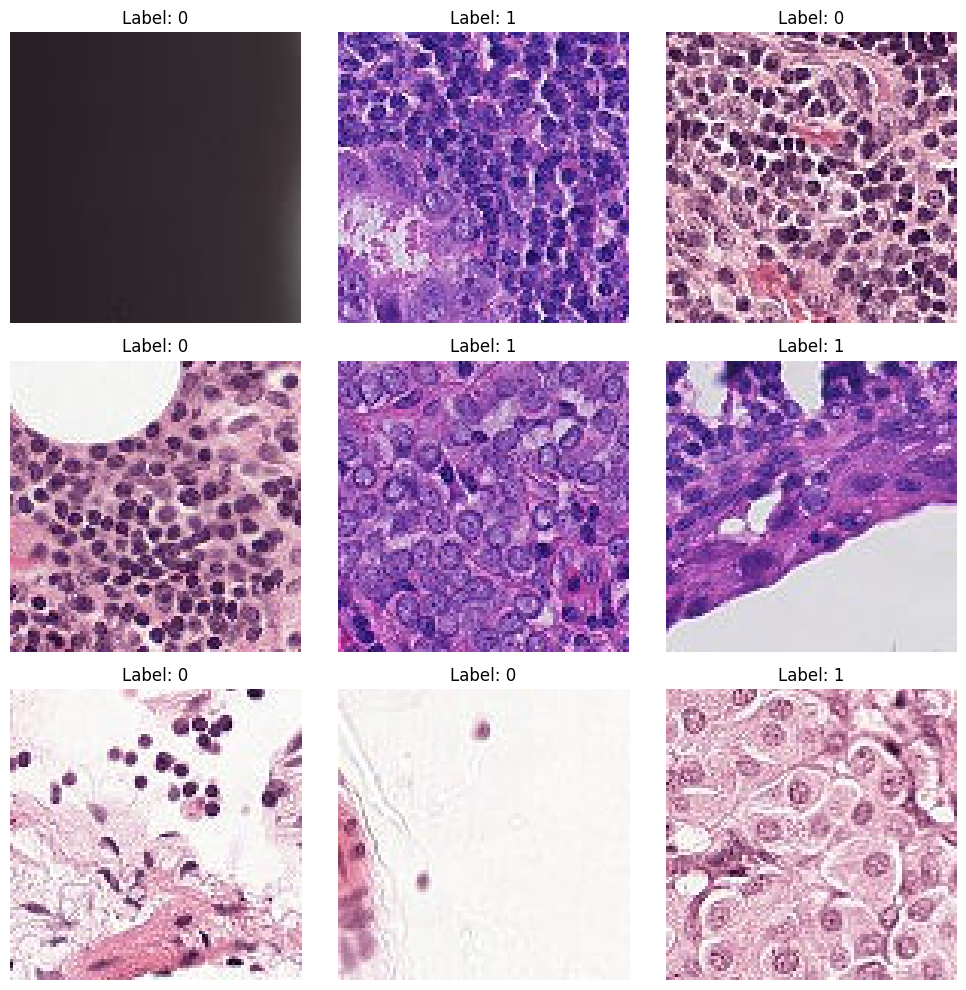

In [4]:
train_dir = "/kaggle/input/histopathologic-cancer-detection/train"
sample_ids = train_labels.sample(9, random_state=42)['id'].values

plt.figure(figsize=(10,10))
for i, img_id in enumerate(sample_ids):
    img_path = os.path.join(train_dir, img_id + ".tif")
    img = Image.open(img_path)
    plt.subplot(3, 3, i+1)
    plt.imshow(img)
    label = train_labels.loc[train_labels['id'] == img_id, 'label'].values[0]
    plt.title(f"Label: {label}")
    plt.axis('off')
plt.tight_layout()
plt.show()

**lets check image characterisitcs**

In [7]:
img_id = train_labels['id'].iloc[0]
img_path = os.path.join(train_dir, img_id + ".tif")
img = Image.open(img_path)
print("Image size:", img.size)  # should be (96, 96)

img_array = np.array(img)
print("Array shape:", img_array.shape)  # should be (96, 96, 3) for RGB
print("Min pixel value:", img_array.min())
print("Max pixel value:", img_array.max())
print("Mean pixel value:", img_array.mean())

Image size: (96, 96)
Array shape: (96, 96, 3)
Min pixel value: 0
Max pixel value: 255
Mean pixel value: 232.89011863425927


# Train-Validation Split (Planning)

In [5]:
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(train_labels, test_size=0.1, stratify=train_labels['label'], random_state=42)

print("Train set size:", len(train_df))
print("Validation set size:", len(val_df))

Train set size: 198022
Validation set size: 22003


# Data Augmentation and Preparation

In [13]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

class HistopathDataset(Dataset):
    def __init__(self, df, image_dir, transform=None):
        self.df = df.reset_index(drop=True)
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_id = self.df.loc[idx, 'id']
        label = self.df.loc[idx, 'label']
        img_path = os.path.join(self.image_dir, img_id + ".tif")
        image = Image.open(img_path)

        if self.transform is not None:
            image = self.transform(image)

        return image, label


train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
])

val_transform = transforms.Compose([
    transforms.ToTensor(),
])

In [14]:
# Paths to data
train_dir = "/kaggle/input/histopathologic-cancer-detection/train"
labels_path = "/kaggle/input/histopathologic-cancer-detection/train_labels.csv"

# Read labels and split into train/validation
labels_df = pd.read_csv(labels_path)
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(labels_df, test_size=0.1, stratify=labels_df['label'], random_state=42)

# Create datasets and loaders
train_dataset = HistopathDataset(train_df, train_dir, transform=train_transform)
val_dataset = HistopathDataset(val_df, train_dir, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=2)

# Defining a Baseline Model

In [15]:
import torch
import torch.nn as nn
from torchvision.models import resnet50

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize ResNet50 without pretrained weights
model = resnet50(weights=None)

# Modify the final layer for binary classification
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 1)
model = model.to(device)

# Loss and Optimizer: Use a binary cross-entropy loss with logits and an Adam optimizer as a starting point.
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Training and Validation Loop
We’ll implement a training loop that runs for a few epochs and monitors validation loss and AUC to see if the model improves.

In [16]:
from sklearn.metrics import roc_auc_score

def evaluate_model(model, dataloader, criterion):
    model.eval()
    val_loss = 0.0
    preds = []
    targets = []
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.float().to(device)
            outputs = model(images)
            loss = criterion(outputs.view(-1), labels)
            val_loss += loss.item() * images.size(0)
            preds.extend(torch.sigmoid(outputs).cpu().numpy())
            targets.extend(labels.cpu().numpy())
    val_loss /= len(dataloader.dataset)
    auc = roc_auc_score(targets, preds)
    return val_loss, auc

# Training Function:
def train_one_epoch(model, dataloader, optimizer, criterion):
    model.train()
    running_loss = 0.0
    for images, labels in dataloader:
        images, labels = images.to(device), labels.float().to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs.view(-1), labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
    return running_loss / len(dataloader.dataset)
    
# Main train Loop
epochs = 5
best_auc = 0.0

for epoch in range(1, epochs+1):
    train_loss = train_one_epoch(model, train_loader, optimizer, criterion)
    val_loss, val_auc = evaluate_model(model, val_loader, criterion)

    print(f"Epoch {epoch}: Train Loss={train_loss:.4f} Val Loss={val_loss:.4f} Val AUC={val_auc:.4f}")

    if val_auc > best_auc:
        best_auc = val_auc
        torch.save(model.state_dict(), "best_model.pth")
        print("New best model saved!")

Epoch 1: Train Loss=0.4215 Val Loss=0.4059 Val AUC=0.9064
New best model saved!
Epoch 2: Train Loss=0.3399 Val Loss=0.3181 Val AUC=0.9396
New best model saved!
Epoch 3: Train Loss=0.2846 Val Loss=0.3518 Val AUC=0.9534
New best model saved!
Epoch 4: Train Loss=0.2487 Val Loss=0.2472 Val AUC=0.9611
New best model saved!
Epoch 5: Train Loss=0.2196 Val Loss=0.5762 Val AUC=0.9330


# **Run Inference on Test Set**

In [17]:
# Create test dataset
class TestDataset(torch.utils.data.Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.image_ids = [f.replace('.tif', '') for f in os.listdir(image_dir) if f.endswith('.tif')]
        self.transform = transform

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        img_id = self.image_ids[idx]
        img_path = os.path.join(self.image_dir, img_id + ".tif")
        image = Image.open(img_path)
        if self.transform is not None:
            image = self.transform(image)
        return image, img_id

test_dir = "/kaggle/input/histopathologic-cancer-detection/test"
test_dataset = TestDataset(test_dir, transform=val_transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Load best model weights
model.load_state_dict(torch.load("best_model.pth"))
model.eval()

# Generate predictions
predictions = []
with torch.no_grad():
    for images, img_ids in test_loader:
        images = images.to(device)
        outputs = model(images)
        probs = torch.sigmoid(outputs).squeeze().cpu().numpy()
        for img_id, prob in zip(img_ids, probs):
            predictions.append([img_id, prob])

/tmp/ipykernel_24/2486866292.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth"))


In [18]:
submission_df = pd.DataFrame(predictions, columns=['id', 'label'])
submission_df.to_csv('submission.csv', index=False)